## Modelagem

### Template - Predição climática

In [1]:
# !pip install awswrangler

In [2]:
# !{sys.executable} -m pip install sagemaker-experiments

In [3]:
import os
import sys
import json
import time
import boto3
import numpy as np
import pandas as pd
from io import StringIO
import awswrangler as wr
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import sagemaker
from sagemaker.session import Session
from sagemaker.analytics import ExperimentAnalytics

sys.path.append(os.path.dirname(os.getcwd())+'/src')
import get_data
import utils

In [4]:
np.random.seed(0)
session = boto3.Session()
sm = session.client('sagemaker')

---

### Input data

In [5]:
bucket='ons-ds-mlops'
training_path = 'framework-overview/data/processed/train/dataset.csv'
validation_path = 'framework-overview/data/processed/validation/dataset.csv'

In [6]:
trainset_uri = f's3://{bucket}/{training_path}'
validationset_uri = f's3://{bucket}/{validation_path}'
print(trainset_uri,'\n', validationset_uri)

s3://ons-ds-mlops/framework-overview/data/processed/train/dataset.csv 
 s3://ons-ds-mlops/framework-overview/data/processed/validation/dataset.csv


In [7]:
train_df = wr.s3.read_csv(trainset_uri, header=None)
train_df.head()

,0,1,2,3,4,5
0,2,0.0,4.7,7.8,8.90,1.000000
1,1,10.9,4.5,7.8,6.70,0.999852
2,1,0.8,2.3,4.5,9.45,0.999408
3,1,20.3,4.7,6.6,8.90,0.998669
4,1,1.3,6.1,6.1,5.85,0.997634


In [8]:
validation_df = wr.s3.read_csv(validationset_uri, header=None)
validation_df.head()

,0,1,2,3,4,5
0,4,0.0,1.2,8.8,1.20,0.999991
1,1,1.5,2.3,5.6,2.80,0.999769
2,3,0.0,1.7,3.3,3.35,0.999251
3,1,10.2,4.5,7.3,6.95,0.998438
4,1,8.1,6.4,2.8,10.80,0.997329


--- 

### Criação do experimento

In [9]:
experiment = utils.create_experiment(
    experiment_prefix="predicao-climatica",
)

In [10]:
print(experiment.experiment_name)

predicao-climatica-2022-08-07-23-09-46


---

### Modelagem

Definição da imagem para treinamento:

In [11]:
container = sagemaker.image_uris.retrieve(region=session.region_name, framework='xgboost', version='latest')

Rodar experimentos:
   
* Descobrir qual a melhor configuração para o modelo de classificação.

In [12]:
hyperparameters_dict = {
    '0':{
        'eta':0.3,
        'gamma':4,
        'max_depth':5,
        'num_round':8,
        'min_child_weight':3,
        'subsample':0.5,
        'objective':"multi:softmax",
        'num_class':5
    },
    '1':{
        'eta':0.1,
        'gamma':4,
        'max_depth':6,
        'num_round':16,
        'min_child_weight':6,
        'subsample':0.9,
        'objective':"multi:softmax",
        'num_class':5
    },
    '2':{
        'eta':0.2,
        'gamma':2,
        'max_depth':6,
        'num_round':20,
        'min_child_weight':6,
        'subsample':0.7,
        'objective':"multi:softmax",
        'num_class':5
    },
    '3':{
        'eta':0.4,
        'gamma':1,
        'max_depth':3,
        'num_round':20,
        'min_child_weight':8,
        'subsample':0.6,
        'objective':"multi:softmax",
        'num_class':5
    }
}

In [13]:
for i in list(hyperparameters_dict.keys()):
    
    trial_, trial_name = utils.log_trial(
        experiment_name=experiment.experiment_name,
        trial_prefix='trial',
        trial_sufix=str(i)
    )
    
    model_uri = f's3://{bucket}/framework-overview/artifacts/experiments'
    utils.train_model(
        container=container,
        trainset_uri=trainset_uri,
        validationset_uri=validationset_uri,
        model_uri=model_uri,
        hyperparameters=hyperparameters_dict[i],
        job_name=trial_name
        )
    
    time.sleep(2)

2022-08-07 23:11:55 Starting - Starting the training job...
2022-08-07 23:12:18 Starting - Preparing the instances for trainingProfilerReport-1659913914: InProgress
.........
2022-08-07 23:13:49 Downloading - Downloading input data...
2022-08-07 23:14:20 Training - Downloading the training image...
2022-08-07 23:14:38 Training - Training image download completed. Training in progress.Arguments: train
[2022-08-07:23:14:37:INFO] Running distributed xgboost training.
[2022-08-07:23:14:37:INFO] Number of hosts: 2, master IP address: 10.0.127.202, host IP address: 10.0.127.202.
[2022-08-07:23:14:37:INFO] Finished Yarn configuration files setup.
starting namenode, logging to /opt/amazon/hadoop/logs/hadoop--namenode-ip-10-0-127-202.ec2.internal.out
Arguments: train
[2022-08-07:23:14:38:INFO] Running distributed xgboost training.
[2022-08-07:23:14:38:INFO] Number of hosts: 2, master IP address: 10.0.127.202, host IP address: 10.0.116.184.
[2022-08-07:23:14:38:INFO] Finished Yarn configuration 

---

### Reading data from experiments

In [14]:
trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=Session(session,sm),
    experiment_name=experiment.experiment_name,
    sort_by='metrics.validation:merror.min',
    sort_order='Ascending',
    metric_names = ['validation:merror'],
    parameter_names = ['max_depth', 'eta', 'gamma', 'min_child_weight', 'subsample']
)

In [15]:
analytic_table = trial_component_analytics.dataframe()

In [16]:
analytic_table.head()

,TrialComponentName,DisplayName,SourceArn,eta,gamma,max_depth,min_child_weight,subsample,validation:merror - Min,validation:merror - Max,...,validation:merror - Last,validation:merror - Count,train - MediaType,train - Value,validation - MediaType,validation - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value,Trials,Experiments
0,trial-2022-08-07-23-11-54-0-aws-training-job,trial-2022-08-07-23-11-54-0,arn:aws:sagemaker:us-east-1:478704051461:train...,0.3,4.0,5.0,3.0,0.5,0.161644,0.167123,...,0.161644,8,csv,s3://ons-ds-mlops/framework-overview/data/proc...,csv,s3://ons-ds-mlops/framework-overview/data/proc...,None,s3://ons-ds-mlops/framework-overview/artifacts...,[trial-2022-08-07-23-11-54-0],[predicao-climatica-2022-08-07-23-09-46]
1,trial-2022-08-07-23-26-25-3-aws-training-job,trial-2022-08-07-23-26-25-3,arn:aws:sagemaker:us-east-1:478704051461:train...,0.4,1.0,3.0,8.0,0.6,0.161644,0.175342,...,0.167123,20,csv,s3://ons-ds-mlops/framework-overview/data/proc...,csv,s3://ons-ds-mlops/framework-overview/data/proc...,None,s3://ons-ds-mlops/framework-overview/artifacts...,[trial-2022-08-07-23-26-25-3],[predicao-climatica-2022-08-07-23-09-46]
2,trial-2022-08-07-23-21-34-2-aws-training-job,trial-2022-08-07-23-21-34-2,arn:aws:sagemaker:us-east-1:478704051461:train...,0.2,2.0,6.0,6.0,0.7,0.164384,0.169863,...,0.164384,20,csv,s3://ons-ds-mlops/framework-overview/data/proc...,csv,s3://ons-ds-mlops/framework-overview/data/proc...,None,s3://ons-ds-mlops/framework-overview/artifacts...,[trial-2022-08-07-23-21-34-2],[predicao-climatica-2022-08-07-23-09-46]
3,trial-2022-08-07-23-16-43-1-aws-training-job,trial-2022-08-07-23-16-43-1,arn:aws:sagemaker:us-east-1:478704051461:train...,0.1,4.0,6.0,6.0,0.9,0.164384,0.169863,...,0.164384,16,csv,s3://ons-ds-mlops/framework-overview/data/proc...,csv,s3://ons-ds-mlops/framework-overview/data/proc...,None,s3://ons-ds-mlops/framework-overview/artifacts...,[trial-2022-08-07-23-16-43-1],[predicao-climatica-2022-08-07-23-09-46]


---

### Implantar melhor variante como um endpoint

Uma vez que o dataset é ordenado de forma crescente para o erro de validação, a melhor variante ocupa a primeira posição. Assim, podemos recuperar o endereço do artefato correspondente ao melhor modelo:

In [17]:
model_uri = analytic_table['SageMaker.ModelArtifact - Value'].iloc[0]

In [18]:
endpoint_name = f"predicao-climatica-{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}"
print(f'nome do endpoint: {endpoint_name}')

utils.deploy_model(
    container=container,
    model_uri=model_uri,
    endpoint_name=endpoint_name
)

nome do endpoint: predicao-climatica-2022-08-07-23-37-53
-------!Endpoint predicao-climatica-2022-08-07-23-37-53 criado com sucesso


---

### Usar endpoint para fazer predições

In [19]:
features = validation_df[validation_df.columns[1:]].copy()
features.head()

,1,2,3,4,5
0,0.0,1.2,8.8,1.20,0.999991
1,1.5,2.3,5.6,2.80,0.999769
2,0.0,1.7,3.3,3.35,0.999251
3,10.2,4.5,7.3,6.95,0.998438
4,8.1,6.4,2.8,10.80,0.997329


In [20]:
output = utils.predict(
    input_data=features,
    endpoint_name=endpoint_name
)

In [21]:
output.head()

,1,2,3,4,5,predicted
0,0.0,1.2,8.8,1.20,0.999991,4
1,1.5,2.3,5.6,2.80,0.999769,1
2,0.0,1.7,3.3,3.35,0.999251,4
3,10.2,4.5,7.3,6.95,0.998438,1
4,8.1,6.4,2.8,10.80,0.997329,1


Criar coluna com valores de referência:

In [22]:
output['true'] = validation_df[validation_df.columns[:1]]
output.head()

,1,2,3,4,5,predicted,true
0,0.0,1.2,8.8,1.20,0.999991,4,4
1,1.5,2.3,5.6,2.80,0.999769,1,1
2,0.0,1.7,3.3,3.35,0.999251,4,3
3,10.2,4.5,7.3,6.95,0.998438,1,1
4,8.1,6.4,2.8,10.80,0.997329,1,1


---

### Avaliação modelo implantado

In [23]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

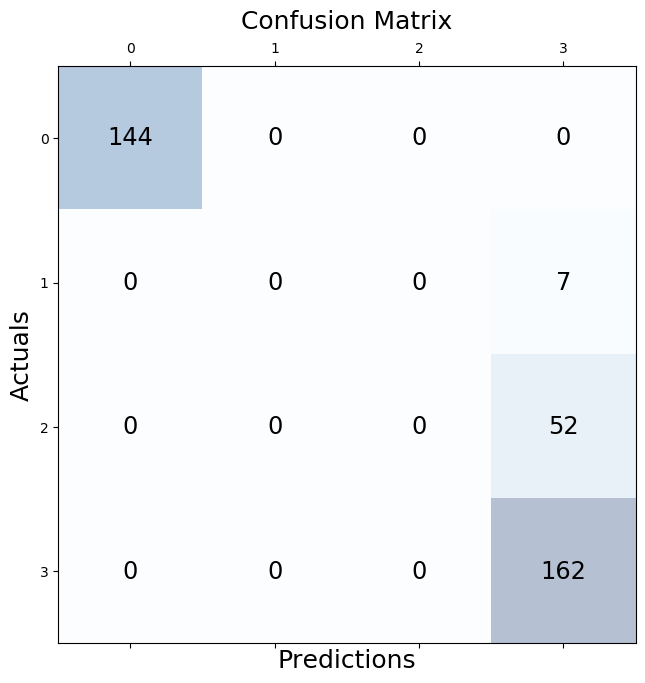

In [24]:
# Visualização de resultados - confusion matrix.
conf_matrix = confusion_matrix(y_true=output['true'], y_pred=output['predicted'])
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [25]:
# Avaliação de métricas - acurácia e F1 score
eval_accuracy = accuracy_score(output['true'], y_pred=output['predicted'])
eval_f1_macro = f1_score(output['true'], y_pred=output['predicted'], average="macro")
eval_f1_micro = f1_score(output['true'], y_pred=output['predicted'], average="micro")

print (
    f"Evaluation result on test data: \n"
    f"{accuracy_score.__name__}: {eval_accuracy} \n"
    f"F1 Macro: {eval_f1_macro} \n"
    f"F1 Micro: {eval_f1_micro} \n"
)

Evaluation result on test data: 
accuracy_score: 0.8383561643835616 
F1 Macro: 0.46148825065274146 
F1 Micro: 0.8383561643835616 



---

### Salvar saída do modelo

In [26]:
output.to_csv(f's3://{bucket}/framework-overview/data/output/dataset.csv', header=False, index=False)

---

### Deletar endpoint

In [27]:
utils.delete_endpoint(
    endpoint_name
)

Endpoint predicao-climatica-2022-08-07-23-37-53 excluído com sucesso


---

### Deletar experimento

In [28]:
utils.delete_experiment(
    experiment.experiment_name
    )

Experimento predicao-climatica-2022-08-07-23-09-46 excluído com sucesso
